# Natural Language Processing - Bill Text Exploration


Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [212]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [213]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [214]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [215]:
df = query('SELECT BillID, Title, Summary, PassH, Cong FROM con_bills.current_bills WHERE Cong >= 110')


In [216]:
df.shape

(51067, 5)

In [217]:
df.tail()

,BillID,Title,Summary,PassH,Cong
51062,114-S-995,A bill to establish congressional trade negoti...,Bipartisan Congressional Trade Priorities and ...,0,114
51063,114-S-996,A bill to facilitate nationwide availability o...,Volunteer Income Tax Assistance (VITA) Act,0,114
51064,114-S-997,A bill to extend the authorization for the maj...,"Department of Veterans Affairs Construction, A...",0,114
51065,114-S-998,A bill to establish a process for the consider...,American Manufacturing Competitiveness Act of ...,0,114
51066,114-S-999,A bill to amend the Small Business Act to prov...,Small Business Development Centers Improvement...,0,114


In [218]:
df['Summary'].isnull().sum()

50

In [219]:
df['Summary'].fillna('None', inplace = True)

In [220]:
df['Summary'].isnull().sum()

0

In [221]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [222]:
blanks = []

for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
    if type(summary)==str:            # avoid NaN values
        if summary.isspace():         # test 'plot' for whitespace
            blanks.append(i)
                  
len(blanks)

0

# Wordcloud Exploration

Initial exploration of topics in dependent variable using wordcloud and stopword engineering.

Pass House 0 = Bills did not pass House

Pass House 1 = Bill passed House


In [223]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.add("concurrent")
stopwords.add("resolution")
stopwords.add("recognizing")
stopwords.add("providing")
stopwords.add("provide")
stopwords.add("bill")
stopwords.add("congressional")
stopwords.add("authorizing")
stopwords.add("authorize")
stopwords.add("designating")
stopwords.add("designate")
stopwords.add("printi")
stopwords.add("printing")
stopwords.add("printed")
stopwords.add("Congress")
stopwords.add("Authorizes")
stopwords.add("Provides")
stopwords.add("Measure")
stopwords.add("Amended")
stopwords.add("Amend")
stopwords.add("Act")
stopwords.add("Amends")

In [224]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords, 
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


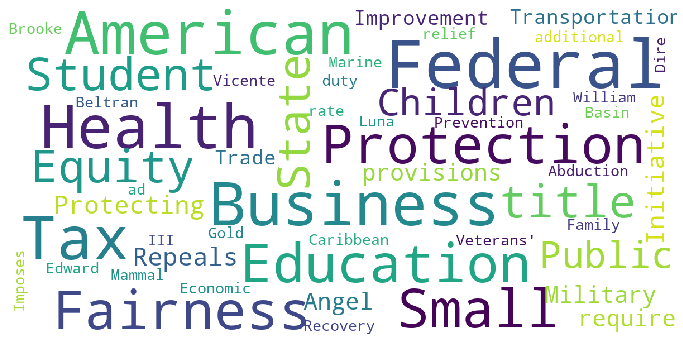

In [225]:
show_wordcloud(df[df['PassH']==0]['Summary'])

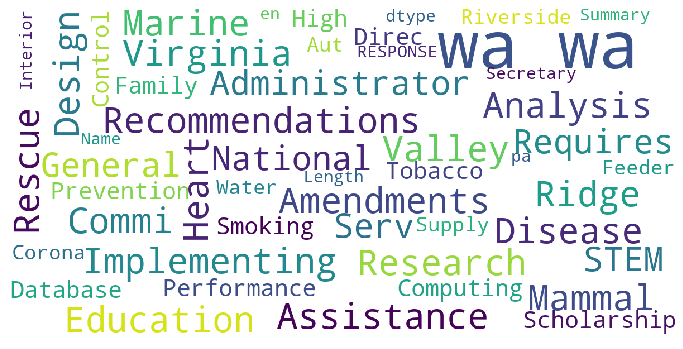

In [226]:
show_wordcloud(df[df['PassH']==1]['Summary'])

In [227]:
#Wordcloud on difference of frequencies

# Topic Modeling

**Split Training and Testing Data**

In [228]:
from sklearn import preprocessing

In [229]:
from sklearn.model_selection import train_test_split

X = df['Summary']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y, )

In [230]:
X_test.head()

41875           Voluntary Verification Program Act of 2015
8138     Emerald Ash Borer Municipality Assistance Act ...
40734    Amends the Internal Revenue Code to make perma...
26483    Amends the Internal Revenue Code to deny a tax...
11522    Motorcoach Enhanced Safety Act of 2009 - Direc...
Name: Summary, dtype: object

In [231]:
df['PassH'].head()

0    1
1    0
2    0
3    0
4    0
Name: PassH, dtype: int64

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [232]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

In [233]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [234]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [235]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [236]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-236-983721234798>:4: DeprecationWarning: invalid escape sequence \[
  replace_with_space = re.compile('[/(){}\[\]\|@,;]')
<ipython-input-236-983721234798>:6: DeprecationWarning: invalid escape sequence \s
  just_words = re.compile('[^a-zA-Z\s]')


In [237]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    #add stopwords
    mytokens = [word for word in mytokens if word not in spacy_stopwords and word not in punctuations]
    
    return mytokens
    

In [238]:
test_fun = df.iloc[3486][2]
test_fun

'Enhancing the Effective Prosecution of Child Pornography Act of 2007 - Amends the federal criminal code to: (1) include child pornography activities and the production of such pornography for importation into the United States as predicate crimes for money laundering prosecutions; and (2) define "possess" with respect to crimes of child sexual exploitation and child pornography to include accessing by computer visual depictions of child pornography with the intent to view.'

In [239]:
tokenizer(test_fun)


['enhance',
 'effective',
 'prosecution',
 'child',
 'pornography',
 'act',
 'amend',
 'federal',
 'criminal',
 'code',
 'include',
 'child',
 'pornography',
 'activity',
 'production',
 'pornography',
 'importation',
 'united',
 'states',
 'predicate',
 'crime',
 'money',
 'laundering',
 'prosecution',
 'define',
 'possess',
 'respect',
 'crime',
 'child',
 'sexual',
 'exploitation',
 'child',
 'pornography',
 'include',
 'accessing',
 'computer',
 'visual',
 'depiction',
 'child',
 'pornography',
 'intent',
 'view']

**Saving to DF**

In [240]:
# df['clean_summaries'] = df.apply(lambda row: clean(row['Summary']), axis=1)

In [241]:
# df['tokenized_summaries'] = df.apply(lambda row: tokenizer(row['Summary']), axis=1)


In [242]:
df.shape

(51067, 5)

**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

In [243]:
#decide if i want to use these

# params = {'vect__max_df': (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 5000, 10000, 50000),
#         'vect__ngram_range': ((1, 1), (1, 2))
#          }

In [245]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, min_df = 0.10) # max_df=0.90, min_df=10
transformed = vectorizer.fit_transform(X_train, y_train)
print(len(vectorizer.get_feature_names()))

15


In [246]:
X_train.head()

34455    Qualifying Renewable Chemical Production Tax C...
29906    Iron Dome Support Act - Authorizes the Preside...
19124    Amends the Harmonized Tariff Schedule of the U...
22463    Nicole's Law - Requires states to have in effe...
48441    Federal Information Security Management Reform...
Name: Summary, dtype: object

In [193]:
# fit and transform training data

# dtm_train_cv = cv.fit_transform(X_train)
# dtm_test_cv = cv.transform(X_test)

**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [194]:
len(vectorizer.get_feature_names())

14927

In [195]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

automatic
burro
apprais
avocados
ask
appropriately
agriculturerelate
childparent
carlstadt
accidentally


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

In [196]:
from sklearn.decomposition import LatentDirichletAllocation

In [197]:
# Build LDA Model
#focus on number topics, max iteration, learning decay

# lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
#                                       max_iter=20,  
#                                       learning_decay=0.5,    # Max learning iterations (how many times going over whole dataset)
# #                                       learning_method='online',   #constantly update with new data or batch
#                                       random_state=42,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )

# print(lda_model)  # Model attributes

In [198]:
# This can take awhile, we're dealing with a large amount of documents!

# lda_output = lda_model.fit_transform(transformed)


**OPTIONAL - Grisearch LDA**

In [199]:
from sklearn.model_selection import GridSearchCV


# Define Search Param
search_params = {'n_components': [15],
                 'learning_decay': [.4]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [200]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.4, 'n_components': 15}
Best Log Likelihood Score:  -1390495.887093651
Model Perplexity:  884.2722745714101


**Gridsearch 1**: 
- Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
- Best Log Likelihood Score:  -751642.0137549518
- Model Perplexity:  921.196053929341

**Gridseach 2**:
-

- Best Model's Params:  {'learning_decay': 0.3, 'n_components': 10}
- Best Log Likelihood Score:  -925062.6312612939
- Model Perplexity:  918.3010429565078

**Model evaluation:**

Look at model components:

In [201]:
best_lda_model.components_

array([[0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       ...,
       [0.06666673, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666823],
       [0.06666667, 1.06666667, 0.06666667, ..., 1.06666667, 1.06666667,
        1.06666356],
       [0.06666679, 0.06666667, 0.06666677, ..., 0.06666667, 0.06666667,
        0.06666667]])

In [202]:
single_topic = best_lda_model.components_[0]

In [203]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([ 8164,  2077,  1061, ..., 14376,  3598, 12189])

In [204]:
# Word least representative of this topic
single_topic[248]

#first round goes from 0.05 to 106.1

0.0666667055544189

In [205]:
# Word most representative of this topic
single_topic[3351]

0.06666666666667084

Look at the top fifteen for each topic:

In [206]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['provide', 'certain', 'affairs', 'authorize', 'defense', 'bill', 'establish', 'program', 'affair', 'veteran', 'direct', 'purpose', 'veterans', 'department', 'secretary']


THE TOP 15 WORDS FOR TOPIC #1
['consumer', 'system', 'fuel', 'agency', 'energy', 'certain', 'vehicle', 'provide', 'safety', 'act', 'amend', 'require', 'bill', 'federal', 'purpose']


THE TOP 15 WORDS FOR TOPIC #2
['bill', 'authorize', 'study', 'post', 'building', 'interior', 'postal', 'states', 'united', 'office', 'locate', 'service', 'designate', 'facility', 'secretary']


THE TOP 15 WORDS FOR TOPIC #3
['improve', 'patient', 'federal', 'program', 'drug', 'food', 'provide', 'public', 'bill', 'care', 'purpose', 'service', 'amend', 'health', 'act']


THE TOP 15 WORDS FOR TOPIC #4
['institution', 'job', 'financial', 'private', 'development', 'amend', 'economic', 'program', 'act', 'investment', 'provide', 'bill', 'small', 'business', 'purpose']


THE TOP 15 WORDS FOR TOPIC #5
['require', 's

In [207]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

#final column shows the topic each document is most 'like'
#topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0.01,0.01,0.01,0.29,0.09,0.14,0.01,0.01,0.01,0.01,0.01,0.41,0.01,0.01,0.01,11
Doc1,0.01,0.01,0.01,0.01,0.01,0.17,0.01,0.01,0.66,0.01,0.01,0.01,0.01,0.1,0.01,8
Doc2,0.01,0.01,0.01,0.01,0.01,0.01,0.13,0.01,0.01,0.79,0.01,0.01,0.01,0.01,0.01,9
Doc3,0,0,0.08,0,0,0,0,0,0.69,0,0,0.14,0,0.05,0,8
Doc4,0.01,0.01,0.01,0.61,0.01,0.01,0.01,0.01,0.32,0.01,0.01,0.01,0.01,0.01,0.01,3
Doc5,0,0,0,0,0,0,0,0.07,0.31,0,0,0.46,0.12,0,0,11
Doc6,0.01,0.01,0.01,0.87,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,3
Doc7,0,0,0,0,0,0,0,0.14,0.21,0,0,0.33,0,0,0.29,11
Doc8,0,0.13,0,0,0,0.22,0.33,0,0,0,0,0.29,0,0,0,6
Doc9,0.01,0.45,0.01,0.01,0.01,0.01,0.01,0.4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1


In [208]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,14,4432
1,8,4066
2,3,4016
3,5,2939
4,13,2788
5,1,2709
6,11,2534
7,7,2301
8,10,2242
9,0,2048


In [209]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in best_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,secretary,department,veterans,purpose,direct,veteran,affair,program,establish,bill,defense,authorize,affairs,certain,provide
Topic 1,purpose,federal,bill,require,amend,act,safety,provide,vehicle,certain,energy,agency,fuel,system,consumer
Topic 2,secretary,facility,designate,service,locate,office,united,states,postal,interior,building,post,study,authorize,bill
Topic 3,act,health,amend,service,purpose,care,bill,public,provide,food,drug,program,federal,patient,improve
Topic 4,purpose,business,small,bill,provide,investment,act,program,economic,amend,development,private,financial,job,institution
Topic 5,security,social,act,program,amend,title,provide,medicare,xviii,purpose,bill,payment,benefit,service,require
Topic 6,energy,bill,federal,provide,government,purpose,project,local,state,act,budget,public,fund,amend,housing
Topic 7,purpose,act,amend,bill,improve,program,technology,water,protection,establish,promote,research,information,development,provide
Topic 8,amend,code,revenue,internal,tax,credit,provide,bill,income,purpose,certain,allow,extend,individual,employee
Topic 9,purpose,child,state,law,amend,immigration,bill,enforcement,certain,act,united,states,provide,nationality,alien


**Dominant topic visualizations**



Topic models only:

In [210]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [211]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, transformed, vectorizer, mds='tsne')
panel

KeyboardInterrupt: 

Visualization using clustering:

In [ ]:
# Construct the k-means clusters
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
#find out how to make in 3D

**Predict a Topic**

In [ ]:
# Define function to predict topic for a given text document.

# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

Other Visualization Examples:
    
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

**Data Mapper Pipeline**


This allow each column to be mapped to different encoders.

https://pypi.org/project/dataframe-mapper/

In [ ]:
# !pip install dataframe-mapper

Should do this for title and summary separately:

In [ ]:
# column_tuples = [
#     ('Sales', None),
#     ('ShelveLoc', LabelEncoder()),
#     ('Urban', LabelEncoder()), 
#     ('US', LabelEncoder())]

# mapper = DataFrameMapper(column_tuples, default=StandardScaler())
# mapper_fit = mapper.fit(train)

# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(tokenizer = tokenizer)
tf_transformed = vectorizer.fit_transform(X_train, y_train)
print(len(tf_vectorizer.get_feature_names()))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
transformed = vectorizer.fit_transform(X)
print "Num words:", len(vectorizer.get_feature_names())